<a href="https://colab.research.google.com/github/kremerlal/techassesment/blob/main/TechAssessment_Kremer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

In [ ]:
df = pd.read_excel('/content/ground_vehicles.xlsx') #put the data set into a dataframe

In [ ]:
df.head() #make sure the data was read in properly

,ID,Contract Number (IDVPIID),Award Number (PIID),Modification Number,Fiscal Year,Title,Awarded Amount,Contracting Office,Contracting Agency,Place of Performance State,Place of Performance City,Vendor Name,Vendor Top Name,PSC Name
0,261901205,NaN,SPE4A616M0117,NaN,2016,"BEARING,PLAIN,SPHER",NaN,DLA Aviation (formerly Defense Supply Center R...,US Department of Defense (DoD),NaN,NaN,Longhorn Regional Service Center LLC,Longhorn Regional Service Center LLC,(31) BEARINGS
1,261915422,NaN,VA26014P1360,P00003,2016,PREVENTATIVE MAINTENANCE SERVICES ON NEPTUNE U...,25990.00,VISN 20: Northwest Network,US Department of Veterans Affairs (VA),OR,Portland,Stryker Corporation,Stryker Corporation,(J065) MAINT/REPAIR/REBUILD OF EQUIPMENT- MEDI...
2,261916094,NaN,VA25912C0281,P00004,2016,IGF::CT::IGF STRYKER SERVICE PLAN FOR VA FORT ...,13053.38,VISN 19: Rocky Mountain Network,US Department of Veterans Affairs (VA),MI,Portage,Stryker Corporation,Stryker Corporation,(J065) MAINT/REPAIR/REBUILD OF EQUIPMENT- MEDI...
3,261919276,NaN,VA25115C0125,P00001,2016,IGF::OT::IGF MAINTENANCE OF PATIENT BEDS OPTIO...,16356.00,VA Ann Arbor Healthcare System,US Department of Veterans Affairs (VA),MI,Ann Arbor,"Imaging Diagnostics, Inc.","Imaging Diagnostics, Inc.",(J065) MAINT/REPAIR/REBUILD OF EQUIPMENT- MEDI...
4,261919325,NaN,VA25114C0139,P00001,2016,IGF::OT::IGF MAINTENANCE OF STRYKER NAV II SYSTEM,68023.62,VA Ann Arbor Healthcare System,US Department of Veterans Affairs (VA),MI,Ann Arbor,Stryker Corporation,Stryker Corporation,(J065) MAINT/REPAIR/REBUILD OF EQUIPMENT- MEDI...


In [ ]:
df.info(verbose=True) #understand the shape of the data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54379 entries, 0 to 54378
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          54379 non-null  int64  
 1   Contract Number (IDVPIID)   40102 non-null  object 
 2   Award Number (PIID)         54254 non-null  object 
 3   Modification Number         52895 non-null  object 
 4   Fiscal Year                 54379 non-null  int64  
 5   Title                       54376 non-null  object 
 6   Awarded Amount              53081 non-null  float64
 7   Contracting Office          54379 non-null  object 
 8   Contracting Agency          54379 non-null  object 
 9   Place of Performance State  52007 non-null  object 
 10  Place of Performance City   52007 non-null  object 
 11  Vendor  Name                54379 non-null  object 
 12  Vendor  Top Name            54379 non-null  object 
 13  PSC Name                    536

The df.info output tells us the ContractNumber has a significant amount (~25%) of missing fields.
Good news, every field has a vendor name. Normalizing might be tricky, but we don't have to augment missing data in those fields.
The Awarded Amount field has some missing values, but it's only ~2%. We will keep tabs on it and see if that is a problem later in the analysis.

A quick glance at the excel document showed that the "Contracting Agency" was not limited to just DoD. We are going to see how much of the data, in volume and dollar amount, is going to DoD. The rest of the analysis will be limited to DoD but this is to check that this data source will give us enough information.

In [ ]:
pd.set_option("display.max_rows", None) #show all rows in the value counts table.
#Quick sanity check that there isn't duplication like "US Department of Defense" with and without parentheses()
df.value_counts(df['Contracting Agency']) #count of rows categorized by each agency

Contracting Agency
US Department of Defense (DoD)                                39422
US Department of Veterans Affairs (VA)                        13337
US Department of Health and Human Services (HHS)                342
Department of Veterans Affairs                                  190
US Department of Justice (DOJ)                                  155
US Department of State (DOS)                                    125
US Department of Homeland Security (DHS)                        110
US Department of the Interior (DOI)                             100
United States General Services Administration (GSA)              81
US Department of Agriculture (USDA)                              60
Government of Canada                                             51
US Department of Commerce (DOC)                                  45
US Department of the Treasury                                    37
US Department of Transportation (DOT)                            29
State of South Carolina      

The majority of this data (by row count) is DoD, so it's a good place to start. Next I want to start to look at the dollar values in the data to make sure it generally aligns with what we're looking for.

In [ ]:
pd.set_option("display.max_rows", 5) #revert back to only showing 5 rows in data tables
df_amt = pd.pivot_table(df, index = ['Contracting Agency'], values = ['Awarded Amount'], aggfunc="sum") #pivot the data by contract agency
df_amt = df_amt.sort_values(by=['Awarded Amount'], ascending=False) #sort by awarded amount

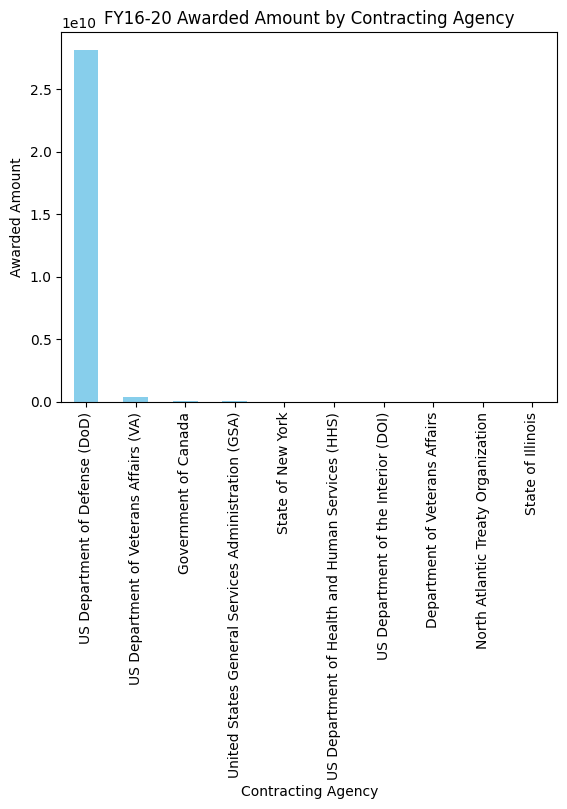

In [ ]:
#show in a bar graph just to understand magnitude
df_amt = df_amt.head(10) #keep only the top 10 agencies
df_amt['Awarded Amount'].plot(kind='bar', color='skyblue')
plt.title('FY16-20 Awarded Amount by Contracting Agency')
plt.ylabel('Awarded Amount')
plt.show()

Sanity check, this data seems to be heavily DoD by dollar amount. I feel good about isolating the data just to DoD.

In [ ]:
df_dod = df.loc[df['Contracting Agency'] == 'US Department of Defense (DoD)'] #isolate data to columns where DoD is the contracting Agency
df_dod.dropna(subset = 'Contracting Agency', inplace=True) #drop any blank rows

<ipython-input-9-0c2a841f7f32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod.dropna(subset = 'Contracting Agency', inplace=True) #drop any blank rows


In [ ]:
df_dod.info()
#the data is 39,422 entries, same as we saw above so the code works.
#awarded amount is in place for 97.5% of the data. with the large amount spent at DoD, that's probably good enough, but we'll keep tabs on it.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39422 entries, 0 to 54376
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          39422 non-null  int64  
 1   Contract Number (IDVPIID)   31105 non-null  object 
 2   Award Number (PIID)         39422 non-null  object 
 3   Modification Number         38445 non-null  object 
 4   Fiscal Year                 39422 non-null  int64  
 5   Title                       39422 non-null  object 
 6   Awarded Amount              38445 non-null  float64
 7   Contracting Office          39422 non-null  object 
 8   Contracting Agency          39422 non-null  object 
 9   Place of Performance State  37640 non-null  object 
 10  Place of Performance City   37640 non-null  object 
 11  Vendor  Name                39422 non-null  object 
 12  Vendor  Top Name            39422 non-null  object 
 13  PSC Name                    389

Now that we've isolated to DoD data...let's see how messy this data is. The client wants to normalize vendor names and contract numbers. Let's clean some data!

1. General normalization

In [ ]:
#what are we working with?
pd.set_option("display.max_rows", 30) #show all rows in the value counts table.
#note: I had this set to None to glance at the vendor names. I changed it to 30 to get a feel for how many less Vendor Names there were after the normalization
#the first problem is the column names have extra spaces...let's fix that
df_dod.columns = df_dod.columns.str.replace(r'\s+', ' ', regex=True).str.strip() #removes extra spaces within the column names
df_dod.columns = [col.strip() for col in df_dod.columns] #strips the extra spaces at the beginning and end, for good measure
df_dod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39422 entries, 0 to 54376
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          39422 non-null  int64  
 1   Contract Number (IDVPIID)   31105 non-null  object 
 2   Award Number (PIID)         39422 non-null  object 
 3   Modification Number         38445 non-null  object 
 4   Fiscal Year                 39422 non-null  int64  
 5   Title                       39422 non-null  object 
 6   Awarded Amount              38445 non-null  float64
 7   Contracting Office          39422 non-null  object 
 8   Contracting Agency          39422 non-null  object 
 9   Place of Performance State  37640 non-null  object 
 10  Place of Performance City   37640 non-null  object 
 11  Vendor Name                 39422 non-null  object 
 12  Vendor Top Name             39422 non-null  object 
 13  PSC Name                    389

In [ ]:
df_dod.value_counts(df_dod['Vendor Name'])

Vendor Name
Howmedica Osteonics Corp.              22525
Beacon Point Associates LLC             2700
General Dynamics Land Systems Inc.      1204
Physio-Control, Inc.                    1156
Stryker Sales, LLC                       799
                                       ...  
Kzf Design Inc.                            1
Kuog Corporation                           1
Kulite Semiconductor Products, Inc.        1
Kranze Technology Solutions, Inc.          1
Zumar Industries, Inc.                     1
Length: 887, dtype: int64

In [ ]:
df_dod.value_counts(df_dod['Vendor Top Name'])

Vendor Top Name
Stryker Corporation             25074
Beacon Point Associates LLC      2700
General Dynamics Corporation     1103
BAE SYSTEMS PLC                   570
General Dynamics Corp.            508
                                ...  
KZF Design Inc.                     1
KRAFT TELEROBOTICS, INC             1
2t-MII Ae, LLC                      1
KFS, LLC                            1
thyssenkrupp AG                     1
Length: 807, dtype: int64

What I see here is inconsistency with punctuation (such as LLC vs L.L.C.) and potentially extraneous spaces. There are some typos, but for the purposes of this assignment I will clean up the systemic issues and group what we need to in Tableau.

For both Vendor Name and Vendor Top Name, we will remove all punctuation and extra spaces. That won't solve every problem, but will get us in the right direction for minimal cleanup.

In [ ]:
# Function to normalize text (remove punctuation and extra spaces)
def normalize_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra spaces
    text = ' '.join(text.split())
    # Make everything lowercase
    text = text.lower()
    return text

In [ ]:
#let's normalize everything that has free text
df_dod['Vendor Name'] = df_dod['Vendor Name'].apply(normalize_text)
df_dod['Vendor Top Name'] = df_dod['Vendor Top Name'].apply(normalize_text)
df_dod['Contracting Office'] = df_dod['Contracting Office'].apply(normalize_text)
#df_dod['Title'] = df_dod['Title'].apply(normalize_text)


<ipython-input-15-60ee1c52759f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['Vendor Name'] = df_dod['Vendor Name'].apply(normalize_text)
<ipython-input-15-60ee1c52759f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['Vendor Top Name'] = df_dod['Vendor Top Name'].apply(normalize_text)
<ipython-input-15-60ee1c52759f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [ ]:
pd.set_option("display.max_rows", 30)
df_dod.value_counts(df_dod['Vendor Top Name'])

Vendor Top Name
stryker corporation                           25074
beacon point associates llc                    2700
general dynamics corporation                   1103
bae systems plc                                 570
general dynamics corp                           508
                                              ...  
2tmii ae llc                                      1
kamlo llc                                         1
kalamazoo manufacturing corporation global        1
john m ellsworth co inc                           1
zumar industries inc                              1
Length: 798, dtype: int64

The function worked as intended, but there is the same amount of unique vendors from before. Tthis will take some more finageling, to get the "General Dynamics Land Systems" combined with "General Dynamics". In previous roles, I've done this kind of data cleaning manually in Excel. It sucks! So Chat GPT introduced me to a package called "fuzzy wuzzy." Let's see if that gets us to where we want to be.

In [ ]:
!pip install fuzzywuzzy
import fuzzywuzzy
from fuzzywuzzy import fuzz
#github: https://github.com/seatgeek/thefuzz#thefuzz

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Fuzzywuzzy uses a calculation to determine how similar two strings are. In the function below, we set a ratio to determine if strings are similar. I don't know what a good benchmark is, so let's determine a benchmark.

If I were doing this manually in Excel, I would see these two names and group them together. Let's see what the ratio is.

In [ ]:
str1 = 'Stryker Corporation'
str2 = 'Stryker Sales LLC'
print(fuzz.partial_ratio(str1.lower(),str2.lower()))

53


53 is way lower than the reccomended 80. Let's set the ratio at 60.

In [ ]:
# Function to group similar strings
def group_similar_strings(data):
    grouped_strings = {}

    for string in data:
        found = False
        for group in grouped_strings:
            # Using partial_ratio to compare strings
            if fuzz.partial_ratio(string, group) >= 80:  #Reccomended threshold. I experimented with other thresholds and this works the best.
                grouped_strings[group].append(string)
                found = True
                break

        if not found:
            grouped_strings[string] = [string]

    return grouped_strings

In [ ]:
# Group similar strings across the entire column
grouped_vendor_name = group_similar_strings(df_dod['Vendor Name'])
grouped_vendor_top_name = group_similar_strings(df_dod['Vendor Top Name'])
grouped_contract_office = group_similar_strings(df_dod['Contracting Office'])

# Create a mapping dictionary to map each original value to its group
map_vendor_name = {value: key for key, values in grouped_vendor_name.items() for value in values}
map_vendor_top_name = {value: key for key, values in grouped_vendor_top_name.items() for value in values}
map_contract_office = {value: key for key, values in grouped_contract_office.items() for value in values}

# Create a new column with the grouped values
df_dod['Vendor Name Clean'] = df_dod['Vendor Name'].map(map_vendor_name)
df_dod['Vendor Top Name Clean'] = df_dod['Vendor Top Name'].map(map_vendor_top_name)
df_dod['Contracting Office Clean'] = df_dod['Contracting Office'].map(map_contract_office)

<ipython-input-22-b0c5830e5afb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['Vendor Name Clean'] = df_dod['Vendor Name'].map(map_vendor_name)
<ipython-input-22-b0c5830e5afb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['Vendor Top Name Clean'] = df_dod['Vendor Top Name'].map(map_vendor_top_name)
<ipython-input-22-b0c5830e5afb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [ ]:
df_dod.head()

,ID,Contract Number (IDVPIID),Award Number (PIID),Modification Number,Fiscal Year,Title,Awarded Amount,Contracting Office,Contracting Agency,Place of Performance State,Place of Performance City,Vendor Name,Vendor Top Name,PSC Name,Vendor Name Clean,Vendor Top Name Clean,Contracting Office Clean
0,261901205,NaN,SPE4A616M0117,NaN,2016,"BEARING,PLAIN,SPHER",NaN,dla aviation formerly defense supply center ri...,US Department of Defense (DoD),NaN,NaN,longhorn regional service center llc,longhorn regional service center llc,(31) BEARINGS,longhorn regional service center llc,longhorn regional service center llc,dla aviation formerly defense supply center ri...
22,262000126,NaN,SPE4A616F0002,NaN,2016,"MODIFICATION KIT,CO",NaN,dla aviation formerly defense supply center ri...,US Department of Defense (DoD),NaN,NaN,l3harris technologies inc,l3harris technologies inc,"(58) COMMUNICATION, DETECTION, AND COHERENT RA...",l3harris technologies inc,l3harris technologies inc,dla aviation formerly defense supply center ri...
23,262000315,NaN,SPE2DS16M0038,NaN,2016,"FIXATION SET,EXTERNAL,ORTHOPEDIC",NaN,dla troop support medical,US Department of Defense (DoD),NaN,NaN,howmedica osteonics corp,stryker corporation,"(65) MEDICAL, DENTAL, AND VETERINARY EQUIPMENT...",howmedica osteonics corp,stryker corporation,dla troop support medical
39,262035006,NaN,W56HZV16D0014,NaN,2016,"VEHICULAR BRAKE, STEERING, AXLE, WHEEL, AND TR...",NaN,acc warren contracting center accwrn,US Department of Defense (DoD),NaN,NaN,seco parts equipment company,seco parts equipment company,(25) VEHICULAR EQUIPMENT COMPONENTS,seco parts equipment company,seco parts equipment company,acc warren contracting center accwrn
190,265007265,NaN,SPE2DS16M0237,NaN,2016,"FIXATION SET,EXTERNAL,ORTHOPEDIC",NaN,dla troop support medical,US Department of Defense (DoD),NaN,NaN,howmedica osteonics corp,stryker corporation,"(65) MEDICAL, DENTAL, AND VETERINARY EQUIPMENT...",howmedica osteonics corp,stryker corporation,dla troop support medical


In [ ]:
# Function to capitalize words based on criteria
def sentence_case(sentence):
    words = sentence.split()
    result = []

    for word in words:
        if len(word) <= 3: #if a word is 3 letters or less capitalize all letters ('bae' => 'BAE')
            result.append(word.upper())
        else:
            result.append(word.title())

    return ' '.join(result)

In [ ]:
df_dod['Vendor Name Clean'] = df_dod['Vendor Name Clean'].apply(sentence_case)
df_dod['Vendor Top Name Clean'] = df_dod['Vendor Top Name Clean'].apply(sentence_case)
df_dod['Contracting Office Clean'] = df_dod['Contracting Office'].apply(sentence_case)

<ipython-input-25-2cf3aa668fa3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['Vendor Name Clean'] = df_dod['Vendor Name Clean'].apply(sentence_case)
<ipython-input-25-2cf3aa668fa3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['Vendor Top Name Clean'] = df_dod['Vendor Top Name Clean'].apply(sentence_case)
<ipython-input-25-2cf3aa668fa3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [ ]:
df_dod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39422 entries, 0 to 54376
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          39422 non-null  int64  
 1   Contract Number (IDVPIID)   31105 non-null  object 
 2   Award Number (PIID)         39422 non-null  object 
 3   Modification Number         38445 non-null  object 
 4   Fiscal Year                 39422 non-null  int64  
 5   Title                       39422 non-null  object 
 6   Awarded Amount              38445 non-null  float64
 7   Contracting Office          39422 non-null  object 
 8   Contracting Agency          39422 non-null  object 
 9   Place of Performance State  37640 non-null  object 
 10  Place of Performance City   37640 non-null  object 
 11  Vendor Name                 39422 non-null  object 
 12  Vendor Top Name             39422 non-null  object 
 13  PSC Name                    389

In [ ]:
df_dod['Award Number (PIID)'].value_counts()

W56HZV15C0095    475
2                223
W56HZV15C0099    189
1                178
W56HZV17C0067    177
                ... 
SPE2D618F1CBL      1
SPE2D618F1CAP      1
SPE2D618F1CAN      1
SPE2D618F1CAC      1
W91YTZ21P0103      1
Name: Award Number (PIID), Length: 23097, dtype: int64

In [ ]:
df_dod[['Award Number (PIID)', 'Contract Number (IDVPIID)']]

,Award Number (PIID),Contract Number (IDVPIID)
0,SPE4A616M0117,NaN
22,SPE4A616F0002,NaN
23,SPE2DS16M0038,NaN
39,W56HZV16D0014,NaN
190,SPE2DS16M0237,NaN
...,...,...
54372,FA489017C0005,NaN
54373,FA489017C0005,NaN
54374,FA489017C0005,NaN
54375,FA489017C0005,NaN


Every row has an Award Number, and award numbers are not unique. Everywhere there is a non-null IDVPIID, the award number doesn't look right.

I'll make a combined PIID field that takes the Contract Number unless it's null, it'll take the award number.

In [ ]:
if [df_dod['Contract Number (IDVPIID)'].isna()]:
  df_dod['PIID Clean'] = df_dod['Award Number (PIID)']
else:
  df_dod['PIID Clean'] = df_dod['Contract Number (IDVPIID)']

<ipython-input-31-8a57e31ae486>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['PIID Clean'] = df_dod['Award Number (PIID)']


In [ ]:
df_dod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39422 entries, 0 to 54376
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          39422 non-null  int64  
 1   Contract Number (IDVPIID)   31105 non-null  object 
 2   Award Number (PIID)         39422 non-null  object 
 3   Modification Number         38445 non-null  object 
 4   Fiscal Year                 39422 non-null  int64  
 5   Title                       39422 non-null  object 
 6   Awarded Amount              38445 non-null  float64
 7   Contracting Office          39422 non-null  object 
 8   Contracting Agency          39422 non-null  object 
 9   Place of Performance State  37640 non-null  object 
 10  Place of Performance City   37640 non-null  object 
 11  Vendor Name                 39422 non-null  object 
 12  Vendor Top Name             39422 non-null  object 
 13  PSC Name                    389

We want to understand what programs are Ground Combat Systems in the data for further analysis. We will add a field called "Ground Combat Systems" with key search terms. These will help us aggregate as needed within Tableau reports.

In [ ]:
df_dod['Title'] = df_dod['Title'].astype(str) #convert contract titles to string

<ipython-input-38-96c50990c026>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['Title'] = df_dod['Title'].astype(str) #convert contract titles to string


In [ ]:
search_words = ['Abrams', 'Bradley', 'Stryker', 'LAV-25', 'LAV-AT', 'LAV-M', 'AMPV']

df_dod['GSC']=df_dod['Title'].apply(lambda row:' '.join(word for word in search_words if word in row))
df_dod['GSC'].value_counts()

<ipython-input-89-8b2e166f00d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dod['GSC']=df_dod['Title'].apply(lambda row:' '.join(word for word in search_words if word in row))


           39269
AMPV          51
Stryker       36
LAV-M         25
Abrams        20
LAV-25        14
LAV-AT         6
Bradley        1
Name: GSC, dtype: int64

To fill in the rows that are associated to the contracts above but may not have the key words, I'll create a lookup table to supplement the rest of the identified rows.

In [ ]:
lookup = df_dod[['PIID Clean', 'GSC']] #create the lookup table
lookup = lookup[lookup['GSC'].str.strip() != ''] #drop the rows where GSC is blank
lookup.drop_duplicates(inplace=True) #drop duplicate contracts

In [ ]:
lookup

,PIID Clean,GSC
315,SPE7LX16D0019,Stryker
830,M6785411C8002,LAV-25
874,W91YTZ-16-P-0039,Stryker
1548,W56HZV10C0077,LAV-M
1611,1,AMPV
...,...,...
46838,N6264521P0001,Stryker
46956,N0025921P0100,Stryker
47077,W81K0221P0045,Stryker
47099,W912QR21C0008,Abrams


In [ ]:
df_dod_export = pd.merge(df_dod, lookup, on='PIID Clean', how='left', copy=False) #merge lookup table and dod dataframe

In [ ]:
df_dod_export.drop(columns='GSC_x', inplace=True)
df_dod_export.rename(columns={"GSC_y": "GSC"}, inplace = True)

In [ ]:
df_dod_export.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39446 entries, 0 to 39445
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          39446 non-null  int64  
 1   Contract Number (IDVPIID)   31105 non-null  object 
 2   Award Number (PIID)         39446 non-null  object 
 3   Modification Number         38469 non-null  object 
 4   Fiscal Year                 39446 non-null  int64  
 5   Title                       39446 non-null  object 
 6   Awarded Amount              38469 non-null  float64
 7   Contracting Office          39446 non-null  object 
 8   Contracting Agency          39446 non-null  object 
 9   Place of Performance State  37640 non-null  object 
 10  Place of Performance City   37640 non-null  object 
 11  Vendor Name                 39446 non-null  object 
 12  Vendor Top Name             39446 non-null  object 
 13  PSC Name                    389

In [ ]:
df_dod_export.to_csv('/content/gsc_export.csv')